In [181]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.special import boxcox1p

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder,  RobustScaler
from sklearn.base import clone
from sklearn.preprocessing import Imputer
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge

import lightgbm as lgb

In [41]:
train = pd.read_csv('train.csv').drop('Id', axis=1)
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
test = pd.read_csv('test.csv')

y = train['SalePrice'].values
y_1p = np.log1p(y)

all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice', 'Id'], axis=1, inplace=True)

In [42]:
# take a peek at the data
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


In [144]:
# my performance benchmark (Root Mean Squared Logrithmic Error)
def rmsle(actual, predicted):
    """
    Computes the root mean squared log error.
    This function computes the root mean squared log error between two lists
    of numbers.
    Parameters
    ----------
    actual : list of numbers, numpy array
             The ground truth value
    predicted : same type as actual
                The predicted value
    Returns
    -------
    score : double
            The root mean squared log error between actual and predicted
    """
    
    def sle(actual, predicted):

        return np.power(np.log(np.array(actual)+1) - np.log(np.array(predicted)+1), 2)
    
    return np.sqrt(np.mean(sle(actual, predicted)))

In [145]:
# seperate into data type
numerical_cols = all_data.select_dtypes(include=[int, float]).columns.tolist()
catigorical_cols = all_data.select_dtypes(exclude=[int, float]).columns.tolist()

RMSLE:     0.12010882846176522
R_squared: 0.8959890990161563


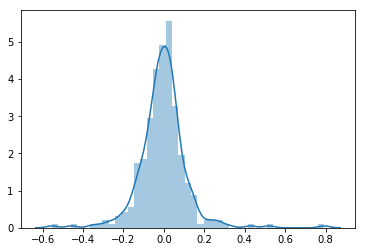

In [185]:
# create poor initial model to set a performance benchmark

num = train[numerical_cols].fillna(0.).astype(float).values
cat = pd.get_dummies(train[catigorical_cols].fillna('o')).astype(float).values

# X = np.concatenate([num, cat], axis=1).astype(float)
X = np.concatenate([num, cat], axis=1)
y = y_1p

# set up training set
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_1p, test_size=0.20)

# ordinary least squares
clf = LinearRegression()
clf.fit(X_train, y_train)

print('RMSLE:     {}'.format(rmsle(np.expm1(y_val), np.expm1(clf.predict(X_val)))))
print('R_squared: {}'.format(clf.score(X_val, y_val)))

ax = sns.distplot((clf.predict(X_val) - y_val))
plt.show()

In [47]:
print('catigorical variables: {}'.format(len(catigorical_cols)))
print('numerical variables:   {}'.format(len(numerical_cols)))

catigorical variables: 43
numerical variables:   36


## Dealing with Missing Catigorical Data

In [48]:
# find columns with missing data
nan = pd.DataFrame()
nan['total'] = all_data.isnull().sum(axis=0).sort_values(ascending=False)
nan['percent'] = nan['total'] / all_data.shape[0]
nan.head()

,total,percent
PoolQC,2908,0.996915
MiscFeature,2812,0.964004
Alley,2719,0.932122
Fence,2346,0.804251
FireplaceQu,1420,0.486802


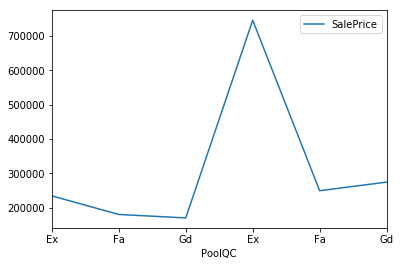

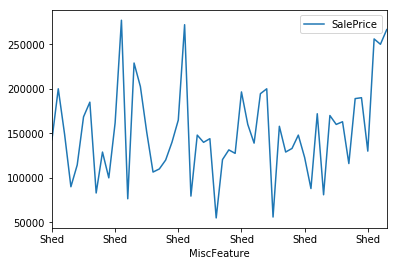

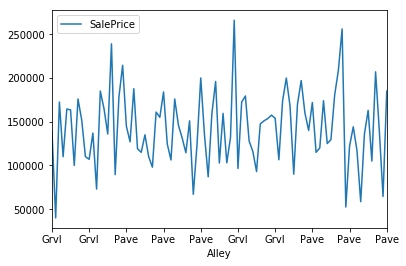

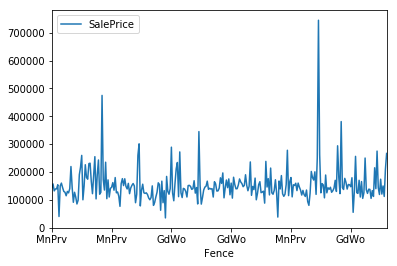

In [49]:
# visually inspect columns with missing data for any trend
cols = nan.head(4).index.tolist()
for col in cols:
    train[[col, 'SalePrice']].dropna().plot(x=col, y='SalePrice')


In [50]:
# drop out top 4 columns that have a ton of nans
catigorical_cols = [x for x in catigorical_cols if x not in nan.head(4).index.tolist()]

In [51]:
# take y out of numerical cols
numerical_cols = [x for x in numerical_cols if x not in ['SalePrice']]

## Preproces Data

In [173]:
# numerical columns
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2',
            'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', "MasVnrArea"):
    all_data[col] = np.log1p(all_data[col].fillna(0.))

In [174]:
# catigorical columns
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'FireplaceQu',
            'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
            'MasVnrType', 'MSSubClass'):
    all_data[col] = all_data[col].fillna('None')
    
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

In [175]:
# fix and label the catigorical data
cat = pd.get_dummies(all_data[catigorical_cols].fillna('none'))

imputer = Imputer(strategy='most_frequent')
num = imputer.fit_transform(all_data[numerical_cols])

processed = np.concatenate([cat, num], axis=1)
processed_1p = np.log1p(processed)

X_tr = processed[:train.shape[0]]
X_te = processed[train.shape[0]:]

# X_tr1 = processed_1p[:train.shape[0]]
# X_te1 = processed_1p[train.shape[0]:]

print(X_tr.shape, X_te.shape, y.shape)

(1458, 302) (1459, 302) (1458,)


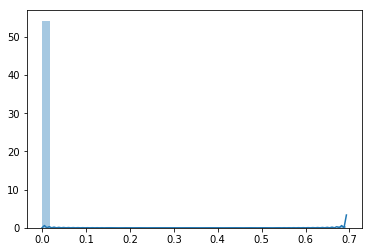

In [176]:
sns.distplot(X_tr1[:, 203].flatten())

## Putting it together

In [177]:

# can cross validate the parameters if you want
min_samples_split = 7
max_depth = 8
max_features='sqrt'
subsample = 0.8 
loss='ls'

param_test = {
#     'n_estimators': np.arange(45, 60, 1),
#           'max_depth': np.arange(10, 30, 2),
#     'max_features': np.arange(1, 40, 3)
#           'min_samples_split': np.arange(2, 10, 1)
#     'alpha': np.arange(0.01, .1, .01),
#     'l1_ratio': np.arange(0, 1, 0.1)
#     'min_samples_leaf': np.arange(1, 10, 1),
    'min_impurity_decrease': np.arange(5, 9, .1) 
}

gboost = GradientBoostingRegressor(loss='huber',
                                      n_estimators=3000,
                                      learning_rate=0.03,
                                      max_depth=4,
                                      min_samples_split=10,
                                      max_features=13)

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

lregress = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=2700,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)


# gsearch1 = GridSearchCV(estimator=rforrest, param_grid=param_test,
#                          n_jobs=-1, cv=10)

# gsearch1.fit(X, y)
# gsearch1.best_params_, 


RMSLE:     0.1254874757034416
R_squared: -2.3080761860094876


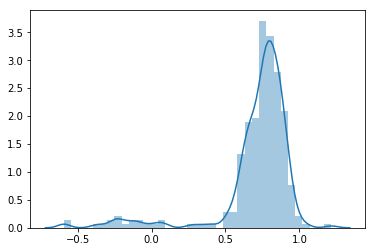

In [178]:
reg = gboost

# set up training set
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_1p, test_size=0.20)

reg.fit(X_train, y_train)
# score.append(rmsle(y_val, reg.predict(X_val)))
    
print('RMSLE:     {}'.format(rmsle(np.expm1(y_val), np.expm1(reg.predict(X_val)))))
print('R_squared: {}'.format(clf.score(X_val, y_val)))

ax = sns.distplot((clf.predict(X_val) - y_val))
plt.show()

# Putting it all together!!

In [140]:
class StackingAveragedModels():
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [179]:
stack_mo = StackingAveragedModels(base_models=[gboost, lregress, lasso], meta_model=lasso)
reg = stack_mo.fit(X_train, y_train)

RMSLE:     0.11642009773594164


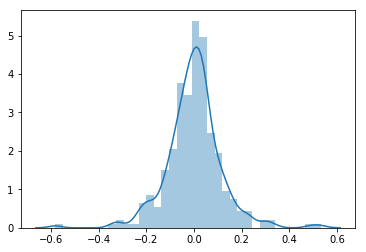

In [180]:
print('RMSLE:     {}'.format(rmsle(np.expm1(y_val), np.expm1(reg.predict(X_val)))))

ax = sns.distplot((reg.predict(X_val) - y_val))
plt.show()